In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

test date range: 01/07/2023 - 30/06/2024

In [4]:
q1_2021 = pd.read_csv('hackathon-online-solar-power-forecasting/Train/Train/2021-1.csv')
q2_2021 = pd.read_csv('hackathon-online-solar-power-forecasting/Train/Train/2021-2.csv')
q3_2021 = pd.read_csv('hackathon-online-solar-power-forecasting/Train/Train/2021-3.csv')
q4_2021 = pd.read_csv('hackathon-online-solar-power-forecasting/Train/Train/2021-4.csv')

q1_2022 = pd.read_csv('hackathon-online-solar-power-forecasting/Train/Train/2022-1.csv')
q2_2022 = pd.read_csv('hackathon-online-solar-power-forecasting/Train/Train/2022-2.csv')
q3_2022 = pd.read_csv('hackathon-online-solar-power-forecasting/Train/Train/2022-3.csv')
q4_2022 = pd.read_csv('hackathon-online-solar-power-forecasting/Train/Train/2022-4.csv')

q1_2023 = pd.read_csv('hackathon-online-solar-power-forecasting/Train/Train/2023-1.csv')
q2_2023 = pd.read_csv('hackathon-online-solar-power-forecasting/Train/Train/2023-2.csv')

In [5]:
solar_prep = pd.concat([q3_2022, q4_2022, q1_2023, q2_2023])
solar_prep['Time'] = pd.to_datetime(solar_prep['Time'], format='%m/%d/%Y %H:%M')
solar_prep

,Time,System Production (W)
0,2022-07-01 00:00:00,0.0
1,2022-07-01 00:15:00,0.0
2,2022-07-01 00:30:00,0.0
3,2022-07-01 00:45:00,0.0
4,2022-07-01 01:00:00,0.0
...,...,...
8731,2023-06-30 22:45:00,0.0
8732,2023-06-30 23:00:00,0.0
8733,2023-06-30 23:15:00,0.0
8734,2023-06-30 23:30:00,0.0


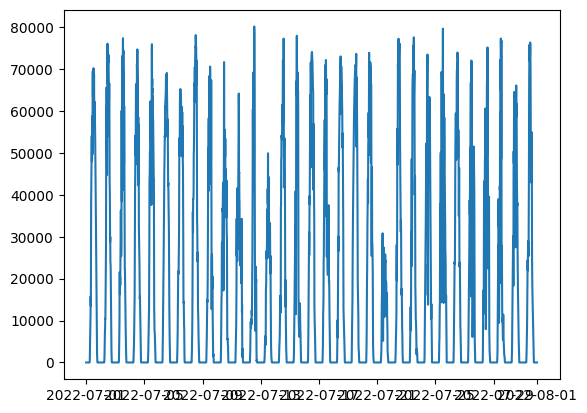

In [6]:
temp = solar_prep[solar_prep['Time'].dt.month == 7]
plt.plot(temp['Time'], temp['System Production (W)'])

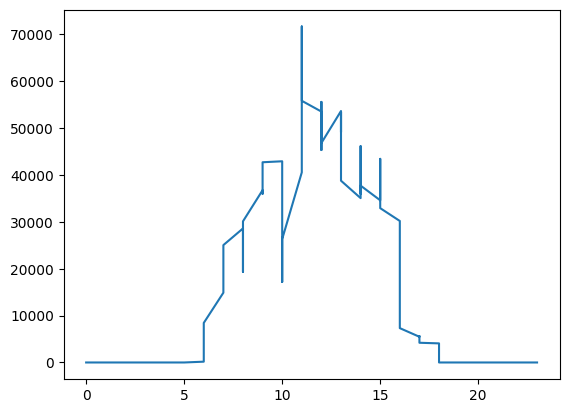

In [7]:
temp_by_date = temp[temp['Time'].dt.day == 10]
plt.plot(temp_by_date['Time'].dt.hour, temp_by_date['System Production (W)'])

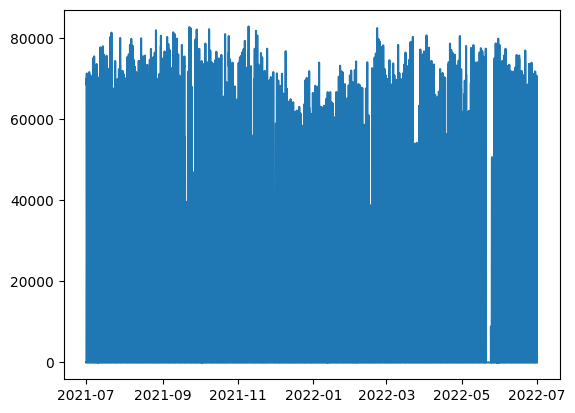

In [8]:
# compare with past 1 year
solar_lag1 = pd.concat([q3_2021, q4_2021, q1_2022, q2_2022])
solar_lag1['Time'] = pd.to_datetime(solar_lag1['Time'], format='%m/%d/%Y %H:%M')
plt.plot(solar_lag1.set_index('Time'))

In [14]:
solar_prep.set_index('Time', inplace=True)

In [18]:
def lag_features(df, start_date, last_date, n=4):
    start_date = pd.to_datetime(start_date, format='%Y-%m-%d')
    last_date = pd.to_datetime(last_date, format='%Y-%m-%d')
    
    temp = df[['System Production (W)']].copy()
    for i in range(1, n + 1):
        temp[f'lag_{i}'] = temp['System Production (W)'].shift(i)

    return temp.loc[start_date: last_date].reset_index()


lag_df = lag_features(solar_prep, '2022-07-01', '2023-06-30')\
            .rename(columns={'System Production (W)': 'Target'})\
            .dropna()
lag_df.head()

,Time,Target,lag_1,lag_2,lag_3,lag_4
4,2022-07-01 01:00:00,0.0,0.0,0.0,0.0,0.0
5,2022-07-01 01:15:00,0.0,0.0,0.0,0.0,0.0
6,2022-07-01 01:30:00,0.0,0.0,0.0,0.0,0.0
7,2022-07-01 01:45:00,0.0,0.0,0.0,0.0,0.0
8,2022-07-01 02:00:00,0.0,0.0,0.0,0.0,0.0


In [49]:
train, valid = np.split(lag_df, [int(len(lag_df)*0.9)])
dates_train, dates_valid = train['Time'], valid['Time']

train.drop(columns='Time', inplace=True)
valid.drop(columns='Time', inplace=True)

X_train, X_valid = train.drop(columns='Target'), valid.drop(columns='Target')
y_train, y_valid = train['Target'], valid['Target']

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


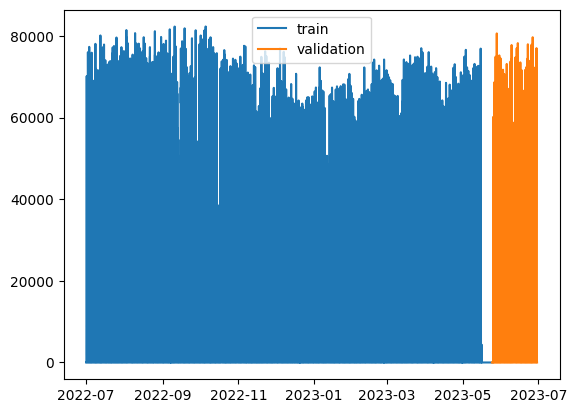

In [50]:
plt.plot(dates_train, y_train, label='train')
plt.plot(dates_valid, y_valid, label='validation')
plt.legend()

### Model selection
- LSTM Model

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [53]:
model = Sequential([
    layers.Input((4, 1)), 
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_squared_error'])

model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100)

Epoch 1/100
983/983 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 740029504.0000 - mean_squared_error: 740029504.0000 - val_loss: 509093024.0000 - val_mean_squared_error: 509093024.0000
Epoch 2/100
983/983 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 401231424.0000 - mean_squared_error: 401231424.0000 - val_loss: 386900096.0000 - val_mean_squared_error: 386900096.0000
Epoch 3/100
983/983 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 351028704.0000 - mean_squared_error: 351028704.0000 - val_loss: 447805248.0000 - val_mean_squared_error: 447805248.0000
Epoch 4/100
983/983 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 398684960.0000 - mean_squared_error: 398684960.0000 - val_loss: 342091616.0000 - val_mean_squared_error: 342091616.0000
Epoch 5/100
983/983 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 372240448.0000 - mean_squared_error: 372240448.0000 - val_loss: 251881312.0000 - val_mean_squared_error: 251881312.0000
Epoch 6/100
983/983 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 343511872.0000 - mean_squared_erro

983/983 ━━━━━━━━━━━━━━━━━━━━ 1s 969us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


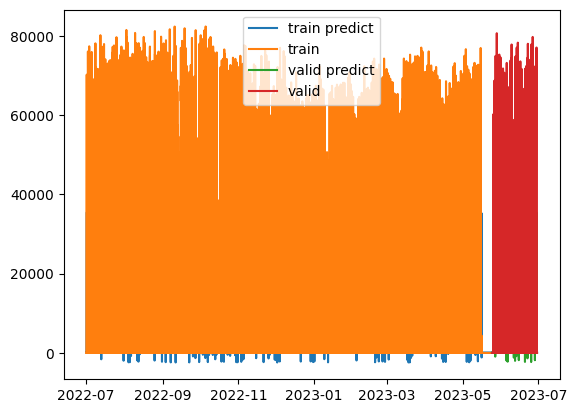

In [54]:
def plot_predictions(model):
    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)

    # plot all of predictions with the observations
    plt.plot(dates_train, train_pred, label='train predict')
    plt.plot(dates_train, y_train, label='train')

    plt.plot(dates_valid, valid_pred, label='valid predict')
    plt.plot(dates_valid, y_valid, label='valid')
    
    plt.legend()
    
    
plot_predictions(model)